# Finetuning AlexNet for Volcanic Deformation Classification #

This tutorial demonstrates how to fine-tune a pre-trained AlexNet model on the LICS dataset, which consists of volcanic InSAR (Interferometric Synthetic Aperture Radar) images. The dataset contains 6,808 images, divided into two categories: 3,605 images displaying deformation signals (class 1 'volcano') and 3,203 images without deformation signals (class 0 'background'). Originally, the pre-trained AlexNet was designed to classify 1,000 types of natural objects, such as tables, cars, dogs, etc. In this tutorial, we will modify the final layer of the neural network to classify images into just two classes instead of the original 1,000.

## Imports ##

We will import the necessary libraries:
- *torch* is the main library that will run the Artificial neural network, called **PyTorch**
- *matplotlib* is for creating graphs
- *numpy* is for storying arrays of data. A few other libraries work only with this (such as matplotlib)
- *sklearn* is a machine learning library that we will use to separate the dataset into train and test
- *torchvision* is a library for loading images as datasets to be used by **PyTorch**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from collections import Counter
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

## Running the models on the GPU ##
We want to run the code on the GPU if possible. Artifial neural networks work faster on a GPU so we will select the device **cuda:0** if it is available.

#### If you encounter problems with the memory, manually setting this to the CPU will solve the problem, but it will also slow down the training process. ####

In [ ]:
# We run the model on the GPU if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# If you get errors about CUDA running out of memory, you can set it to run on the CPU by uncommenting the next line.
# device = torch.device("cpu")

## Loading the dataset ##
We will load the **LICS** dataset that contains two folders, one with images of **volcanoes** and one with images of **background**.

We need to define the transformations that will be applied to the images. In this case, we will only transform the images into **tensors**, which is how **PyTorch** stores and uses data.

In [3]:
dataset_dir = 'LiCS'

# Transformers applied to the dataset
data_transforms = transforms.Compose([
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root=dataset_dir, transform=data_transforms)
class_names = dataset.classes

# Show information about the dataset
print(f'Dataset size: {len(dataset)}')
print(f'Mapping from class names to indexes: {dataset.class_to_idx}')
print(f'Number of samples per class: {dict(Counter(dataset.targets))}')

Dataset size: 6808
Mapping from class names to indexes: {'background': 0, 'volcano': 1}
Number of samples per class: {0: 3203, 1: 3605}


## Splitting the dataset into train and test ##

**PyTorch** allows us to split a dataset into two parts only at random, so if we want to have the same number of images from each class into both the train and the test dataset, we need to use a function from **sklearn**: *train_test_split*.

In [4]:
train_dataset_size = 2000
test_dataset_size = 200

targets = np.array(dataset.targets)
# The two classes are unbalanced with 'volcano' having more images. Thus we remove some of them. 
# All the 3203 'background' images are in front, followed by the 3605 'volcano' images. 
# So from the array with all the images, we can select the first 6406 images, which is all the 'background' ones followed by 3203 'volcano' ones.
# Thus, we select the first 6406 images from the dataset.
targets = targets[:6406]
train_indices, test_indices = train_test_split(
    np.arange(targets.shape[0]),
    train_size=train_dataset_size,
    test_size=test_dataset_size,
    stratify=targets,
)

# We use the splits we obtained to create subsets of the main dataset, one for train and one for test
train_dataset = Subset(dataset, indices=train_indices)
test_dataset = Subset(dataset, indices=test_indices)

# Show information about our subsets
train_classes = [dataset.targets[i] for i in train_dataset.indices]
print(f'Numner of samples per class for the train dataset: {dict(Counter(train_classes))}')

test_classes = [dataset.targets[i] for i in test_dataset.indices]
print(f'Numner of samples per class for the test dataset: {dict(Counter(test_classes))}')

Numner of samples per class for the train dataset: {1: 1000, 0: 1000}
Numner of samples per class for the test dataset: {1: 100, 0: 100}


## Creating a DataLoader ##

A **DataLoader** is responsible for loading the data, in our case images, from the disk into memory during training or testing. 

We need to decide how many images are loaded at once by setting *batch_size* and how many cores of the CPU work on loading the images by setting *num_workers*. 

The *batch_size* option influences how fast and efficient the model trains, but a bigger batch size also means more memory is required. 

The *num_workers* option should be set depending on how many cores your CPU has. Settings the number of workers to a bigger value than the total number of cores in the CPU will not speed up the process, it might even slow it down. 

Finally, *shuffle* decides if the order in which the images are loaded is random or not. We will make the order random for training but not for testing.

#### If you get an error like this: *torch.cuda.OutOfMemoryError: CUDA out of memory*, one way of solving it is to choose a smaller number for the *batch_size* option. If this doesn't work, as a last resort, you can choose to run the model on the CPU instead of the GPU from the second code cell. ####

In [5]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True
)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=False
)

## Visualizing the dataset ##

We will create a function to visualize some of the images inside the dataset. Then we will load some images using the train dataloader and visualize them.

In [6]:
def imshow(img, title=None):
    img = img.numpy()
    img = img[0]
    img = img * 2 * np.pi - np.pi
    plt.imshow(img, cmap='jet', vmin=-np.pi, vmax=np.pi)
    plt.colorbar()
    if title is not None:
        plt.title(title)
    plt.show()

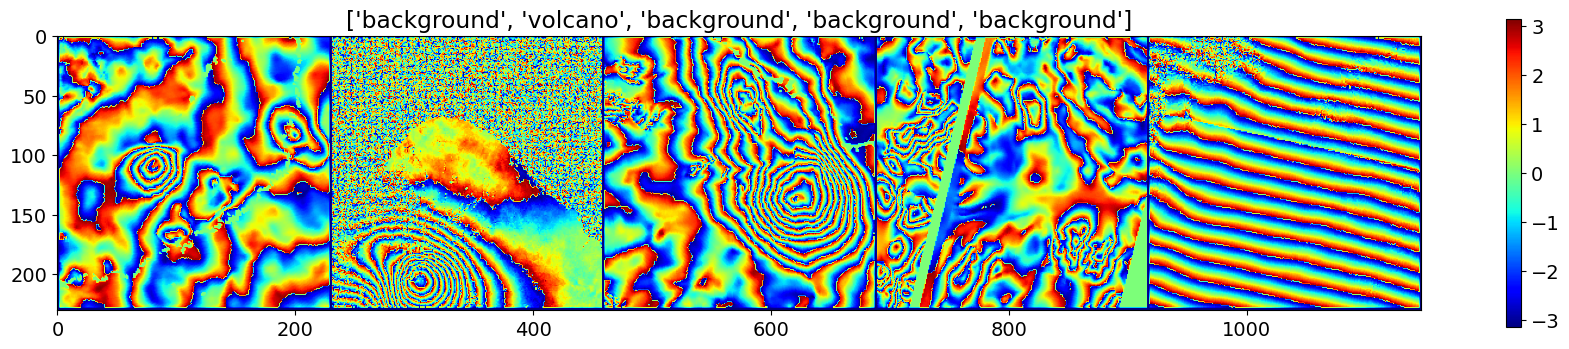

In [7]:
plt.rc('font', size=14) 
plt.rcParams['figure.figsize'] = [22, 4]

# Get a batch of training data
inputs, labels = next(iter(train_dataloader))
# We will show only the first 5 images
inputs = inputs[:5]
labels = labels[:5]

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in labels])

## Training an Artificial Neural Network ##

### Introduction ###
Artificial Neural Networks, or ANNs for short, are Machine Learning models inspired by biological neural networks that are found in animal brains. 

An ANN is a collection of nodes called artificial neurons that abstract the neurons found in a brain. An artificial neuron, like its biological counterpart, receives signals from other neurons, processes them and sends its own signal to other neurons connected to it. The signal, or the input, received from a connection with another neuron is a real number, and each connection has a weight associated with it that is adjusted during training. The output of the neuron is computed by applying a non-linear function to the weighted sum of the inputs. Neurons are generally grouped into layers and each layer may perform a different transformation to its inputs. The first layer is called the input layer and it has the same number of neurons as the number of dimensions of the input. The last layer is called the output layer and the layers in-between are known as hidden layers. An example of a network is presented in the figure below. 

<div>
<center><img src="images/ann.png" width="800" alt="ANN"/></center>
</div>

The model for one neuron is:
\begin{align*}
y = \varphi((\sum_{i} w_i x_i) - b)
\end{align*}
where $x_i$ is the i<sup>th</sup> input received, $w_i$ is the weight adjusting that input, $\varphi$ is a non-linear function, $b$ is the bias and $y$ is the output.

The input of the network is a feature vector $\mathbf{x} = \mathbf{x}^0$. Denoting all the weights of a neuron as $\mathbf{w} = [w_0 w_1 \dots]$ and the weights of all neurons in a layer as $W = [\mathbf{w_0} \mathbf{w_1} \dots]$, the output of a layer $l$ can be written as: 
\begin{align*}
\mathbf{y}^l = \varphi(W^l \mathbf{x}^l - \mathbf{b}^l)
\end{align*}
The output of the network will be a vector $\mathbf{y}^N$, with $N$ being the number of layers in the network.

### The Backpropagation Algorithm ###
#### Intuition ####

In order for the network to learn, an algorithm is needed to update the weights of the neurons such that the output of the network gets closer to the desired one. 

In supervised learning, each input $\mathbf{x}^0$ is paired with an output $\mathbf{y}^*$. In a classification problem, $\mathbf{y}^*$ will be a one-hot vector with the bit that represents the class of the input set to $1$.

The loss function or cost function $\mathcal{L}(\mathbf{y}^N, \mathbf{y}^*)$ is a function that computes the distance between the current output of the network and the desired one. The gradient descent method relies on calculating the derivative of the loss function with respect to the weights of the network. 

\begin{align*}
\frac{\partial \mathcal{L}}{\partial \mathbf{y}^l} &= \frac{\partial \mathcal{L}}{\partial \mathbf{y}^{l+1}} \frac{\partial \mathbf{y}^{l+1}}{\partial \mathbf{y}^{l}} \\
\frac{\partial \mathcal{L}}{\partial W^l} &= \frac{\partial \mathcal{L}}{\partial \mathbf{y}^l} \frac{\partial \mathbf{y}^l}{\partial W^l}
\end{align*}

The weights can then be updated:
\begin{equation*}
W^l \leftarrow W^l - \eta\frac{\partial \mathcal{L}}{\partial W^l}
\end{equation*}
where $\eta > 0$ is a given learning rate.

#### Loss function ####

The loss function needs to fulfil the following conditions:
- it has a derivative
- it is written as a function of the outputs of the network
- it can be written as an average $\mathcal{L}(Y^N, Y^*) = \frac{1}{n} \sum_\mathbf{y} \mathcal{L}(\mathbf{y}^N, \mathbf{y}^*) $


The last condition exists because a network is trained, in general, with a set of samples at once, known as a batch. The aim of training the network is to achieve a loss equal to $0$ on the entire dataset, as such using the whole dataset at once to calculate the gradient would be ideal. Unfortunately, this is unfeasible on big datasets. For this reason, small batches that fit into memory are used instead. They provide a more accurate update for the weights than using one sample at a time, while not being too computationally and memory intensive. 
Splitting the dataset into multiple batches, and then iterating over all of them is known as an epoch. 


#### The algorithm ####

Since calculating the gradient of the weights depends only on the output of the current and next layer, the Backpropagation algorithm calculates the updates for the entire network starting from the last layer. The current result is then used to calculate the gradients for the previous layer until the entire network is updated. The stopping criteria for the algorithm could be completing a number of epochs, achieving a certain accuracy or not producing any significant changes. The algorithm can be seen below.

<div>
<center><img src="images/backpropagation.png" width="600" alt="Backpropagation"/></center>
</div>

### Learning methods ###

Online gradient descent uses one sample per iteration, which only roughly approximates aspects of the cost function. This results in a noisy gradient descent that may not find the local minimum. Deterministic gradient descent uses the entire dataset in every iteration and, given enough time, will find the true local minimum. As discussed previously, this has a high computational cost and is not usable in practice. Stochastic gradient descent (SGD) uses a batch of samples in every iteration, thus achieving a good approximation of the real gradient. This especially reduces the computational cost for high-dimensional optimization problems, in trade for a lower convergence rate.

Many improvements have been proposed to SGD. In machine learning, in particular, the result of gradient descent relies too much on setting a good learning rate. Setting this parameter too high will result in the algorithm diverging, meanwhile setting it too low will make learning slow. Denoting $\Delta\mathcal{J}(X, W_t) = \frac{\partial \mathcal{L}}{\partial W_t}$ as the steepest gradient for input $X$ and weights $W_t$ at iteration $t$, the SGD learning rule can be written as:

\begin{equation*}
W_{t+1} = W_t - \eta\Delta\mathcal{J}(X, W_t)
\end{equation*}


## Choosing a pre-trained network ##
We will use a pre-trained network to speed up our training time.
We can use the command below to check all the available pre-trained networks in **PyTorch**.

In [8]:
models.list_models()

['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'deeplabv3_mobilenet_v3_large',
 'deeplabv3_resnet101',
 'deeplabv3_resnet50',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'fasterrcnn_mobilenet_v3_large_320_fpn',
 'fasterrcnn_mobilenet_v3_large_fpn',
 'fasterrcnn_resnet50_fpn',
 'fasterrcnn_resnet50_fpn_v2',
 'fcn_resnet101',
 'fcn_resnet50',
 'fcos_resnet50_fpn',
 'googlenet',
 'inception_v3',
 'keypointrcnn_resnet50_fpn',
 'lraspp_mobilenet_v3_large',
 'maskrcnn_resnet50_fpn',
 'maskrcnn_resnet50_fpn_v2',
 'maxvit_t',
 'mc3_18',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'mvit_v1_b',
 'mvit_v2_s',
 'quantized_googlenet',
 '

## AlexNet ##

We will choose AlexNet as our pre-trained network.
We also check the name of all the layers, as we need to know the name of the last layer. We will replace this layer.

In [9]:
model = models.alexnet(weights='DEFAULT') # equivalent to ``models.alexnet(weights='IMAGENET1K_V1')``
print(model.children)

<bound method Module.children of AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216

## Replace the last layer of the network ##

We need to replace the last layer of the network with one that fits our case. Since we have two classes, *volcanoes* and *background*, we need a layer with 2 neurons.
The last layer, or the output layer, is the 6<sup>th</sup> layer in the classifier part of the network. Initially, it has an input of 4096 numbers and an output of 1000 numbers. The input cannot be changed, since it comes from the previous layer, but we will change the output to just 2 numbers. 

In [10]:
# We take the last layer in the network, which is the output layer. In this case it is the 6-th layer inside `classifier`
print(model.classifier[6])
in_features = model.classifier[6].in_features
print(in_features)

# We replace the last layer and set the output size to 2 since we have 2 classes
model.classifier[6] = nn.Linear(in_features, 2)

Linear(in_features=4096, out_features=1000, bias=True)
4096


## Loss function and Optimizer ##

We define a loss function and an optimizer. The loss function will be Cross Entropy Loss and the optimizer will be Adam. 

#### Cross Entropy Loss ####
Cross Entropy is a loss function that is calculated as such:

\begin{align*}
l_n &= \log \frac{\exp{Y_{n,\mathbf{y}^*_n}}}{\sum^C_{c=1} \exp Y_{n,c}} \\
l(Y, \mathbf{y}^*) &= \frac{1}{N} \sum_{n = 1}^N l_n
\end{align*}

where $Y$ is a 2-dimensional matrix representing the output of the network for a batch, $\mathbf{y}^*$ is a vector with the targets for that batch (1-D and not in one-hot form), $N$ is the size of the batch, $C$ is the number of classes, $\mathbf{y}^*_n$ represents the n<sup>th</sup> label in the targets, $Y_{n,\mathbf{y}^*_n}$ represents the $\mathbf{y}^*_n$<sup>th</sup> dimension of the n<sup>th</sup> output of the batch and $Y_{n,c}$ represents the c<sup>th</sup> dimension of the n<sup>th</sup> output.

#### Adam ####

Adaptive Moment Estimation (Adam) is an optimizer, where running averages of both the gradients and the second moments of the gradients are used:

\begin{align*}
G_{t+1} &= \alpha G_t + (1 - \alpha) \Delta\mathcal{J}(X, W_{t}) \\
\overline{G} &= \frac{G_{t+1}}{1 - \alpha^t} \\
A_{t+1} &= \beta A_t + (1 - \beta)(\Delta\mathcal{J}(X, W_{t}))^2 \\
\overline{A} &= \frac{A_{t+1}}{1 - \beta^t} \\
W_{t+1} &= W_t - \eta\frac{\overline{G}}{\sqrt{\overline{A}} + \varepsilon}
\end{align*}

where $\alpha$ and $\beta$ are the forgetting factors for gradients and second moments of gradients, respectively. Squaring and square-rooting is done element-wise.

In [11]:
# We move the model to the selected device (either GPU or CPU)
model = model.to(device)

# We define a loss function
criterion = nn.CrossEntropyLoss()

# We define an optimizer
# All parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=25 * 1e-5)

## Training and Testing ##

For training, we get a batch of images and we run the batch through the model and get an output. We use the loss function to get a loss value.

By calling *loss.backwards()*, we calculate the gradient of the loss value by using the Backpropagation algorithm. 
We can then call *optimizer.step()* to update the weights of the network and perform the gradient descent. Since the function *step()* is called on the optimizer, the selected optimizing algorithm is used to update the weights.

For testing, we don't need to calculate the gradient. In order to calculate the gradient, **PyTorch** saves all the operations performed on the data. This uses memory and is unnecessary during testing. Thus, we need to call *torch.no_grad()*. This tells the **PyTorch** library not to save the following operations.

In [12]:
def evaluate_model(model, criterion):
    # Testing phase
    # We need to set the model to evaluation mode
    model.eval()
    
    total_loss = 0.0
    total_correct_preds = 0

    with torch.no_grad():  
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
    
            # get output of model
            outputs = model(inputs)
            # the prediction is the class with the highest probability
            _, preds = torch.max(outputs, 1)
            # calculate the loss
            loss = criterion(outputs, labels)
    
            # stats
            total_loss += loss.item() * inputs.size(0)
            total_correct_preds += torch.sum(preds == labels.data)
            
    test_loss = total_loss / len(test_dataloader.dataset)
    test_acc = total_correct_preds.double() / len(test_dataloader.dataset)

    print(f'Test Loss: {test_loss:.4f} Accuracy: {test_acc:.4f}')

    return test_loss, test_acc


def train_model(model, criterion, optimizer, epochs=25, save_path='results/', save_name='best_model_params.pt', eval_interval=1):
    start_time = time.time()
    
    if not os.path.isdir(save_path):
        os.mkdir(save_path) 
    model_params_path = os.path.join(save_path, save_name)

    torch.save(model.state_dict(), model_params_path)
    best_acc = 0.0

    for epoch in range(1, epochs + 1):
        print(f'Epoch {epoch} / {epochs}')
        print('*' * 20)

        epoch_start = time.time()
        # Training phase
        # We need to set the model to training mode
        model.train()
        
        total_loss = 0.0
        total_correct_preds = 0

        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # get output of model
            outputs = model(inputs)
            # the prediction is the class with the highest probability
            _, preds = torch.max(outputs, 1)
            # calculate the loss
            loss = criterion(outputs, labels)

            # backpropagation + optimize the weights
            loss.backward()
            optimizer.step()

            # Batch stats
            total_loss += loss.item() * inputs.size(0)
            total_correct_preds += torch.sum(preds == labels.data)


        # Epoch stats
        epoch_loss = total_loss / len(train_dataloader.dataset)
        epoch_acc = total_correct_preds.double() / len(train_dataloader.dataset)

        print(f'Training Loss: {epoch_loss:.4f} Accuracy: {epoch_acc:.4f}')
        

        if epoch % eval_interval == 0:
            test_loss, test_acc = evaluate_model(model, criterion)

            # save the model
            if test_acc > best_acc:
                best_acc = test_acc
                torch.save(model.state_dict(), model_params_path)

        print()
        time_elapsed = time.time() - epoch_start
        print(f'Epoch complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print()
    
    time_elapsed = time.time() - start_time
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best evaluation Accuracy: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(torch.load(model_params_path, weights_only=True))
    return model

## Running the model ##

Now we can just call the training function to train the model on our dataset.

In [13]:
model_conv = train_model(model, criterion, optimizer, epochs=5, 
                         save_path='results/', save_name='best_model_params.pt', eval_interval=1)

Epoch 1 / 5
********************
Training Loss: 0.2390 Accuracy: 0.9030
Test Loss: 0.1057 Accuracy: 0.9500

Epoch complete in 0m 38s

Epoch 2 / 5
********************
Training Loss: 0.0929 Accuracy: 0.9680
Test Loss: 0.0893 Accuracy: 0.9550

Epoch complete in 0m 41s

Epoch 3 / 5
********************
Training Loss: 0.0423 Accuracy: 0.9875
Test Loss: 0.0624 Accuracy: 0.9800

Epoch complete in 0m 42s

Epoch 4 / 5
********************
Training Loss: 0.0272 Accuracy: 0.9920
Test Loss: 0.0252 Accuracy: 0.9950

Epoch complete in 0m 41s

Epoch 5 / 5
********************
Training Loss: 0.0189 Accuracy: 0.9945
Test Loss: 0.1679 Accuracy: 0.9300

Epoch complete in 0m 45s

Training complete in 3m 26s
Best evaluation Accuracy: 0.995000


## Visualizing the predictions of the model ##

Finally, we can visualize the predictions of the model.

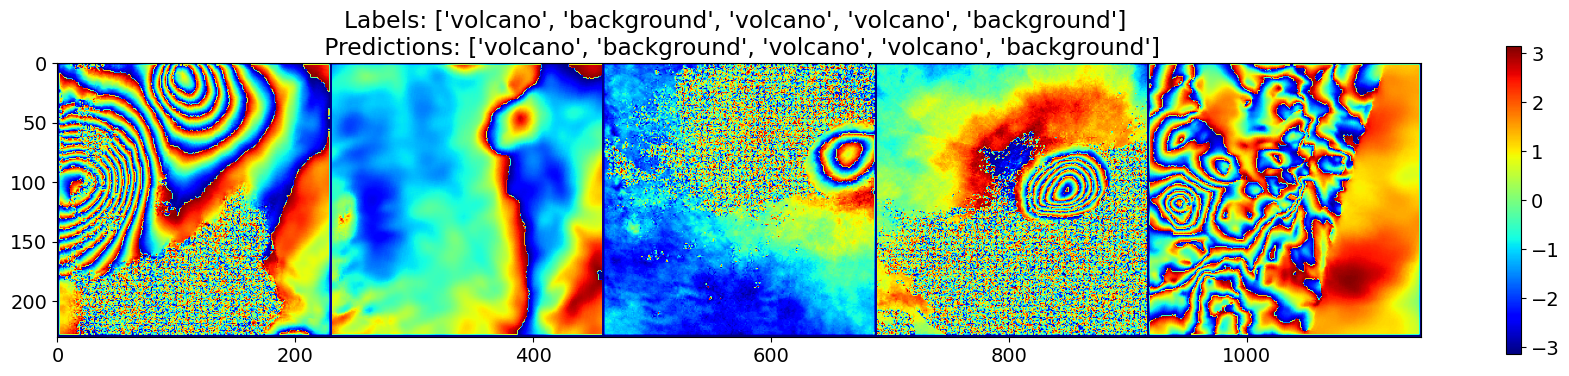

In [14]:
# Get a batch of testing data
inputs, labels = next(iter(test_dataloader))
# We will show only the first 5 images
inputs = inputs[:5]
labels = labels[:5]

with torch.no_grad():
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    preds = outputs.argmax(-1)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
title = f'Labels: {[class_names[x] for x in labels]} \n Predictions: {[class_names[x] for x in preds]}'

imshow(out, title=title)